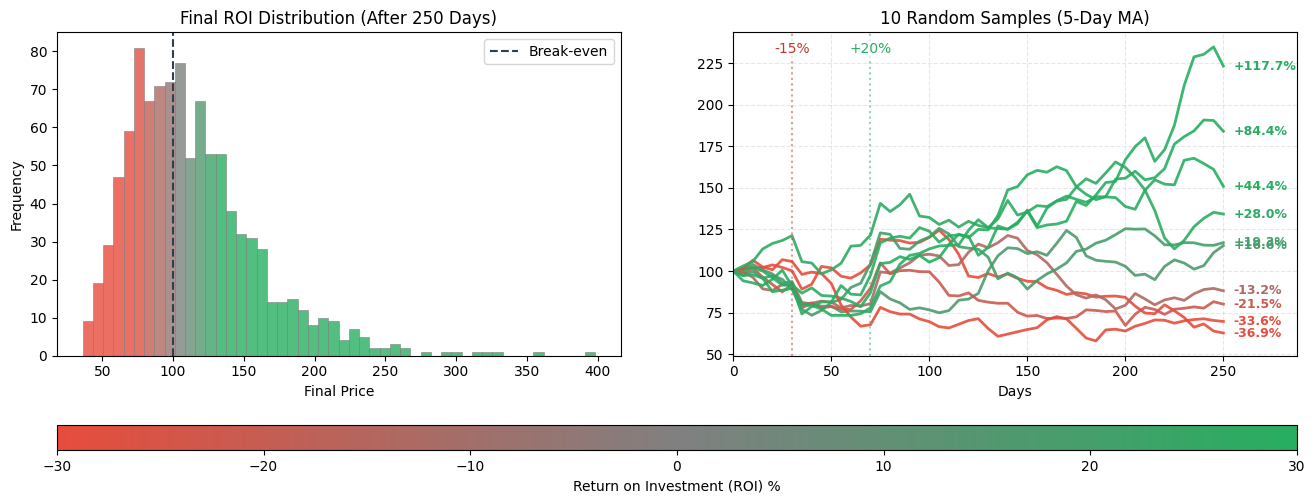

In [52]:
# @title 📈 Stock Simulator Configuration Panel { run: "auto" }

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Configuration Area (Colab Form) ---
# @markdown ### Time and Scale Settings
init_p = 100 #@param {type:"number"}
days = 250 #@param {type:"slider", min:10, max:1000, step:10}
sims = 1000 #@param {type:"slider", min:100, max:5000, step:100}
ma_window = 5 #@param {type:"slider", min:1, max:50, step:1}

# @markdown ### Risk and Return Display Settings
vmin = -30 #@param {type:"number"}
vmax = 30 #@param {type:"number"}

# @markdown ### Special Events (Format: (Day, Change Rate))
my_events = [(30, -0.15), (70, 0.20)]

# --- Simulation Function ---
def simulate_stock(initial_price=100, days=100, simulations=100, drift=0.0005,
                   base_volatility=0.02, limit=0.10, manual_events=None):
    paths = np.zeros((days + 1, simulations))
    paths[0] = initial_price
    # Filter events exceeding simulation days to prevent index out of bounds
    event_dict = {d: v for d, v in manual_events if d <= days} if manual_events else {}

    for s in range(simulations):
        current_vol = base_volatility
        for d in range(1, days + 1):
            # Dynamic volatility adjustment
            current_vol = current_vol * 0.9 + (np.random.rayleigh(base_volatility)) * 0.1
            shock = np.random.normal(drift, current_vol)
            if d in event_dict:
                actual_move = event_dict[d]
            else:
                # Apply price limit constraints
                actual_move = np.clip(shock, -limit, limit)
            paths[d, s] = paths[d-1, s] * (1 + actual_move)
    return paths

# Create color mapping
cmap = mcolors.LinearSegmentedColormap.from_list("rg_cmap", ["#e74c3c", "#808080", "#27ae60"])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# --- Execute Simulation ---
data = simulate_stock(initial_price=init_p, days=days, simulations=sims, manual_events=my_events)

# --- Plotting Logic ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribution Plot
final_prices = data[-1, :]
n, bins, patches = ax1.hist(final_prices, bins=50, edgecolor='grey', linewidth=0.5, alpha=0.8)

for b, patch in zip(bins, patches):
    roi_at_bin = (b - init_p) / init_p * 100
    patch.set_facecolor(cmap(norm(roi_at_bin)))

ax1.axvline(init_p, color='#2c3e50', linestyle='--', label='Break-even')
ax1.set_title(f'Final ROI Distribution (After {days} Days)', fontsize=12)
ax1.set_xlabel('Final Price')
ax1.set_ylabel('Frequency')
ax1.legend()

# 2. Line Chart (Sample Paths)
sample_indices = np.random.choice(data.shape[1], 10, replace=False)
for idx in sample_indices:
    path = data[:, idx]
    current_roi = (path[-1] - init_p) / init_p * 100

    # Corrected Moving Average logic to adapt to day changes
    ma_path = [np.mean(path[max(0, k-ma_window+1):k+1]) for k in range(0, len(path), ma_window)]
    x_axis = np.arange(0, len(path), ma_window)
    if x_axis[-1] != len(path) - 1:
        ma_path.append(np.mean(path[-ma_window:]))
        x_axis = np.append(x_axis, len(path) - 1)

    line_color = cmap(norm(current_roi))
    ax2.plot(x_axis, ma_path, alpha=0.9, linewidth=2, color=line_color)
    ax2.text(x_axis[-1] + (days * 0.02), ma_path[-1], f'{current_roi:+.1f}%',
             color=line_color, fontsize=9, va='center', fontweight='bold')

# Event Markers (Only mark events within the day range)
for day, impact in my_events:
    if day <= days:
        e_color = '#c0392b' if impact < 0 else '#27ae60'
        ax2.axvline(x=day, color=e_color, linestyle=':', alpha=0.5)
        ax2.text(day, ax2.get_ylim()[1] * 0.95, f'{impact:+.0%}',
                 color=e_color, fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

ax2.set_title(f'10 Random Samples ({ma_window}-Day MA)', fontsize=12)
ax2.set_xlabel('Days')
ax2.set_xlim(0, days * 1.15) # Dynamically adjust X-axis to leave room for percentage text
ax2.grid(True, linestyle='--', alpha=0.3)

# Unified Color Bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='horizontal', pad=0.15, aspect=50)
cbar.set_label('Return on Investment (ROI) %')

plt.show()